# Import and optimization

In [25]:
!pip install missingno phik boule osfclient cartopy pygeodesy

  Using cached boule-0.5.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached osfclient-0.0.5-py2.py3-none-any.whl.metadata (5.5 kB)
  Using cached pygeodesy-25.5.28-py2.py3-none-any.whl.metadata (20 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
Using cached boule-0.5.0-py3-none-any.whl (37 kB)
Using cached osfclient-0.0.5-py2.py3-none-any.whl (39 kB)
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
    --------------------------------------- 0.3/10.9 MB ? eta -:--:--
   ---- ----------------------------------- 1.3/10.9 MB 6.1 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/10.9 MB 4.4 MB/s eta 0:00:03
   ------- -------------------------------- 2.1/10.9 MB 3.6 MB/s eta 0:00:03
   --------- ------------------------------ 2.6/10.9 MB 3.0 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/10.9 MB 3.2 MB/s eta 0:00:03
   ---------------- ----------------------- 4.5/10.9 MB 3.4 MB/s eta 0:00:02
   -------------------

In [26]:
# !osf -p  8zvwm clone

In [27]:
# import urllib.request
# url = 'https://sourceforge.net/projects/geographiclib/files/geoids-distrib/egm2008-1.tar.bz2'
# filename = 'Data/egm2008-1.tar.bz2'
# urllib.request.urlretrieve(url, filename)

In [28]:
# ! tar  -xvf  Data/egm2008-1.tar.bz2

In [29]:
import pandas as pd
import numpy as np

import seaborn as sns
import missingno
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import plotly.express as px
import phik
from pygeodesy import GeoidKarney, LatLon_

from sklearn.model_selection import train_test_split


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
class CFG:
    TARGET = 'gravity(mGal)'
    N_FOLDS = 5
    RANDOM_STATE = 3

    COLORADO_PATH = './Data/Colorado_gravity_data.dat'
    GRAVD_PATH = './Data/GRAVD_ms05_median_debiased_1hz.txt'

In [8]:
class DataLoader:
    def __init__(self, colorado: pd.DataFrame, gravd: pd.DataFrame):
        self.colorado = colorado
        self.gravd = gravd
        self.log_features = []  # Список признаков для трансформации
        self.X = None
        self.y = None
    

    @staticmethod
    def reduce_mem_usage(dataframe):
        """ 
        Уменьшает использование памяти dataframe путем преобразования типов данных
        с автоматическим пропуском временных столбцов
        """
        start_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Изначальное использование памяти: {start_mem:.2f} MB")
        
        for col in dataframe.columns:
            col_type = dataframe[col].dtype
            
            # Пропускаем временные столбцы и категориальные данные
            if str(col_type).startswith('datetime') or str(col_type) == 'category':
                continue
                
            if col_type != object:
                c_min = dataframe[col].min()
                c_max = dataframe[col].max()
                
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        dataframe[col] = dataframe[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        dataframe[col] = dataframe[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        dataframe[col] = dataframe[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        dataframe[col] = dataframe[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        dataframe[col] = dataframe[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        dataframe[col] = dataframe[col].astype(np.float32)
                    else:
                        dataframe[col] = dataframe[col].astype(np.float64)
            else:
                # Оптимизация строковых столбцов
                dataframe[col] = dataframe[col].astype('category')
        
        end_mem = dataframe.memory_usage().sum() / 1024**2
        print(f"Итоговое использование памяти: {end_mem:.2f} MB")
        print(f"Экономия {(start_mem - end_mem) / start_mem * 100:.1f}%")
        
        return dataframe


    def load(self, option='compare'):
        print(f'Loading data')
        print(f'Choosed option:{option}')

        if option == 'compare':
            self.colorado = self.colorado.merge(self.gravd, left_on='latitude(deg)', right_on='lat(deg)', how='outer')
        elif option == 'ground':
            pass

        self.colorado = self.reduce_mem_usage(self.colorado)

In [9]:
class DataAnalysis:

    @staticmethod
    def info_df(df: pd.DataFrame) -> None:
        print('------------------------------')
        print('| Dataset information |')
        print('------------------------------')
        df.info()
        print('-----------------------------------------')
        print('| First 5 rows |')
        print('-----------------------------------------')
        display(df.head())
        print('--------------------')
        print('| Sum of duplicates |')
        print('--------------------')
        print(df.duplicated().sum())


    @staticmethod
    def view_distribution(data: pd.DataFrame, object_col = False, numeric_col = False) -> None:
        numeric_cols = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        object_cols = data.select_dtypes(include=['object']).columns.to_list()
        
        if numeric_col:
            fig, axes = plt.subplots(nrows=len(data[numeric_cols].columns), ncols=2, figsize=(len(numeric_cols)+15,len(numeric_cols)+7))
            j = 0
            for i in data[numeric_cols].columns:
                sns.histplot(data[numeric_cols][i], ax=axes[j, 0], kde=True, bins=40, edgecolor='black')
                axes[j, 0].set_title(i, fontsize=14)
                axes[j, 0].set_xlabel('')

                sns.boxplot(x=data[numeric_cols][i], ax=axes[j, 1], orient='h', palette='pink')
                axes[j, 1].set_title(i, fontsize=14)
                axes[j, 1].set_xlabel('')
                j += 1
            plt.suptitle(f'Num features\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.tight_layout();
            plt.show();

        if object_col:
            _,ax = plt.subplots(len(object_cols),1, figsize=(len(object_cols)+7,len(object_cols)+20));
            ax =ax.flatten();
            g = 0
            for k in data[object_cols].columns:
                sns.countplot(data=data, x=k,ax=ax[g]);
                ax[g].set_xticklabels(labels=ax[g].get_xticklabels());
                ax[g].set_title(k);
                ax[g].set_xlabel('');
                g += 1
            plt.suptitle(f'Categorical\n\n', ha='center', fontweight='bold', fontsize=20);
            plt.show();


    @staticmethod
    def bloating_of_variance(data: pd.DataFrame) -> None:
        num = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()
        vif_data = pd.DataFrame()
        vif_data['feature'] = data.select_dtypes(exclude=['object', 'datetime']).columns.to_list()

        vif_data['VIF'] = [variance_inflation_factor(data[num].values, i) \
                                for i in range(len(data[num].columns))]
        print(vif_data)
    
    @staticmethod
    def balance_of_target(data: pd.DataFrame, target: str) -> None:
        sns.countplot(y=target, data=data, color='green', width=0.6);

    @staticmethod
    def plot_count(df: pd.core.frame.DataFrame, col: str, title_name: str='Train') -> None:
        # Set background color
        f, ax = plt.subplots(1, 2, figsize=(16, 7))
        plt.subplots_adjust(wspace=0.2)

        s1 = df[col].value_counts()
        N = len(s1)

        outer_sizes = s1
        inner_sizes = s1/N

        colors = sns.color_palette("mako")
        # hex_colors = [matplotlib.colors.to_hex(color) for color in colors]
        # print(hex_colors)
        
        outer_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        inner_colors = ['#2e1e3b', '#413d7b', '#37659e', '#348fa7', '#40b7ad', '#8bdab2']
        #inner_colors = ['#59b3a3',] #'#433C64']

        ax[0].pie(
            outer_sizes,colors=outer_colors, 
            labels=s1.index.tolist(), 
            startangle=90, frame=True, radius=1.3, 
            explode=([0.05]*(N-1) + [.3]),
            wedgeprops={'linewidth' : 1, 'edgecolor' : 'black'}, 
            textprops={'fontsize': 12, 'weight': 'bold', 'color': 'white'}
        )

        textprops = {
            'size': 13, 
            'weight': 'bold', 
            'color': 'white'
        }

        ax[0].pie(
            inner_sizes, colors=inner_colors,
            radius=1, startangle=90,
            autopct='%1.f%%', explode=([.1]*(N-1) + [.3]),
            pctdistance=0.8, textprops=textprops
        )

        center_circle = plt.Circle((0,0), .68, color='black', fc='#243139', linewidth=0)
        ax[0].add_artist(center_circle)

        x = s1
        y = s1.index.tolist()
        sns.barplot(
            x=x, y=y, ax=ax[1],
            palette=colors, orient='horizontal'
        )

        ax[1].spines['top'].set_visible(False)
        ax[1].spines['right'].set_visible(False)
        ax[1].tick_params(
            axis='x',         
            which='both',      
            bottom=False,       
            labelbottom=False
        )

        for i, v in enumerate(s1):
            ax[1].text(v, i+0.1, str(v), color='white', fontweight='bold', fontsize=12)

        plt.setp(ax[1].get_yticklabels(), fontweight="bold")
        plt.setp(ax[1].get_xticklabels(), fontweight="bold")
        ax[1].set_xlabel(col, fontweight="bold", color='white')
        ax[1].set_ylabel('count', fontweight="bold", color='white')

        f.suptitle(f'{title_name}', fontsize=14, fontweight='bold', color='white')
        plt.tight_layout() 
        plt.show()
    
    @staticmethod
    def summary(data: pd.DataFrame) -> None:
        data = data.select_dtypes(exclude=['object', 'datetime'])
        sum = pd.DataFrame(data.dtypes, columns=['dtypes'])
        sum['missing#'] = data.isna().sum()
        sum['missing%'] = (data.isna().sum())/len(data)
        sum['uniques'] = data.nunique().values
        sum['count'] = data.count().values
        sum['skew'] = data.skew().values
        return sum
    
    @staticmethod
    def correlations(data: pd.DataFrame) -> None:
        data = data.drop(columns=CFG.TARGET)
        plt.figure(figsize=(15, 13));
        # Generate a mask for the upper triangle
        mask_pir = np.triu(np.ones_like(data.corr(method='pearson'), dtype=bool));
        mask_spi = np.triu(np.ones_like(data.corr(method='spearman'), dtype=bool));
       
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(11, 9));

        # Generate a custom diverging colormap
        cmap = sns.diverging_palette(230, 20, as_cmap=True);
        plt.title('PIRSON')
        sns.heatmap(data.corr(method='pearson'), annot=True, mask=mask_pir, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True);
        plt.show();
        
        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        plt.title('SPEARMAN')
        sns.heatmap(data.corr(method='spearman'), annot=True, mask=mask_spi, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, robust=True)
        plt.show();

        plt.figure(figsize=(15, 13));
        f, ax = plt.subplots(figsize=(11, 9));
        
        interval_cols = data.select_dtypes(exclude='object').columns.to_list()
        phik_overview = data.phik_matrix(interval_cols=interval_cols)
        plt.title(r'$\phi_K$')
        corr = phik_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=.3, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        significance_overview  = data.significance_matrix(interval_cols=interval_cols)

        plt.figure(figsize=(15, 13));
        plt.title('Statistical significance')
        corr = significance_overview.round(2)
        mask = np.triu(np.ones_like(corr, dtype=bool))
        sns.heatmap(corr, mask=mask, cmap='pink_r', vmax=5, vmin=-5, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})

        plt.show()
    
    @staticmethod
    def blinks(data: pd.DataFrame) -> None:
        print('Data gaps')
        missingno.matrix(data)

In [13]:
loader = DataLoader(
    colorado=pd.read_csv(CFG.COLORADO_PATH, 
                      names=['latitude(deg)', 'longitude(deg)', 'orthometric height above MSL(m)', 'gravity(mGal)', 'survey ID', 'year'],
                        skipinitialspace=True,
                        sep=' '),
    gravd=pd.read_csv(CFG.GRAVD_PATH,
                        skipinitialspace=True),
)

In [14]:
loader.load(option='ground')

Loading data
Choosed option:ground
Изначальное использование памяти: 2.71 MB
Итоговое использование памяти: 0.79 MB
Экономия 70.8%


In [15]:
loader.colorado.head()

,latitude(deg),longitude(deg),orthometric height above MSL(m),gravity(mGal),survey ID,year
0,37.06250,253.000,2222.0,979220.3125,746,9999
1,37.06250,253.000,2128.0,979239.4375,746,9999
2,37.03125,253.125,2262.0,979223.8750,746,9999
3,37.03125,252.625,1854.0,979277.0625,746,9999
4,37.03125,252.750,1897.0,979277.0625,5908,9999


In [16]:
loader.colorado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59303 entries, 0 to 59302
Data columns (total 6 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   latitude(deg)                    59303 non-null  float16
 1   longitude(deg)                   59303 non-null  float16
 2   orthometric height above MSL(m)  59303 non-null  float16
 3   gravity(mGal)                    59303 non-null  float32
 4   survey ID                        59303 non-null  int16  
 5   year                             59303 non-null  int16  
dtypes: float16(3), float32(1), int16(2)
memory usage: 810.9 KB


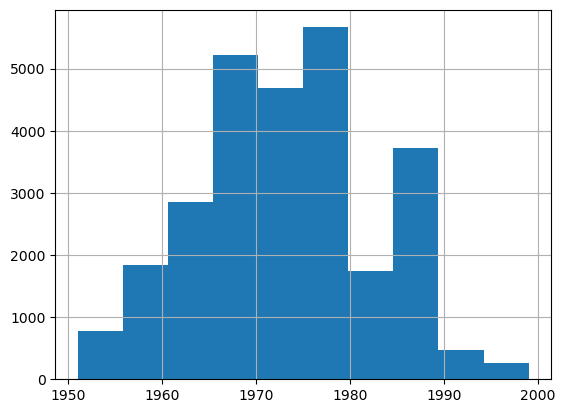

In [17]:
loader.colorado.query('year < 9999 and year > 1950')['year'].hist();

In [18]:
loader.colorado = loader.colorado.loc[(loader.colorado['year'] < 9999) & (loader.colorado['year'] > 1950)]

In [19]:
# for data in [loader.colorado]:
#     DataAnalysis.info_df(data)
#     DataAnalysis.blinks(data)
#     DataAnalysis.view_distribution(data, numeric_col=True)
#     DataAnalysis.correlations(data)

In [20]:
DataAnalysis.summary(loader.colorado).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,skew
latitude(deg),float16,0,0.000000,161,27200,-0.428955
longitude(deg),float16,0,0.000000,57,27200,-0.239624
orthometric height above MSL(m),float16,0,0.000000,2061,27200,nan
gravity(mGal),float32,0,0.000000,9452,27200,0.551018
survey ID,int16,0,0.000000,85,27200,0.399701
year,int16,0,0.000000,37,27200,0.210000


In [21]:
loader.colorado.describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
latitude(deg),27200.000000,inf,1.390625,35.000000,36.968750,38.031250,39.000000,40.000000
longitude(deg),27200.000000,inf,1.408203,250.000000,253.125000,254.000000,254.500000,258.000000
orthometric height above MSL(m),27200.000000,inf,inf,951.500000,1875.000000,2330.000000,2742.000000,4400.000000
gravity(mGal),27200.000000,979275.625000,246.731293,978784.250000,979175.125000,979241.031250,979362.843750,979822.437500
survey ID,27200.000000,5028.142978,2029.088465,393.000000,3814.000000,4737.000000,6053.000000,12516.000000
year,27200.000000,1973.325772,9.049233,1951.000000,1968.000000,1971.000000,1979.000000,1999.000000


In [22]:
loader.colorado.drop_duplicates(inplace=True)
loader.colorado.reset_index(drop=True, inplace=True)

# Features

In [23]:
FEATURES = ['latitude(deg)', 'longitude(deg)', 'orthometric height above MSL(m)', CFG.TARGET]
df = loader.colorado[FEATURES]
df.head()

,latitude(deg),longitude(deg),orthometric height above MSL(m),gravity(mGal)
0,36.50000,250.500,1631.0,979346.0000
1,36.46875,250.625,1747.0,979328.1250
2,36.43750,250.750,2144.0,979252.8750
3,36.40625,250.750,1904.0,979303.6875
4,36.34375,250.750,2084.0,979268.5000


In [32]:
geoidinterpolator=GeoidKarney('geoids/egm2008-1.pgm')

In [43]:
class Gravity:
    def __init__(self):
        pass

    @staticmethod
    def height_anomaly(B: float, L: float) -> float:
        ll = LatLon_(latlonh=B, lon=L, wrap=True) # преобразование в формат библиотеки pygeodesy
        h_anomaly = geoidinterpolator(ll)
        return h_anomaly
    
    
    @staticmethod
    def gamma_mean(B: float, L: float, H: float) -> float:
        # программа составлена по нормальным формулам для расчета силы тяжести, Огородова Л. В. "Высшая геодезия", 2006, стр 85, формула 3.65 и 3.74
        # параметры нормальной земли взяты из приказа "Об утверждении геометрических и физических числовых геодезических параметров
        # государственной геодезической системы координат 2011 года"
        gamma_e=978032.696
        beta=0.00530243
        beta1=0.00000585
        norm_gravity_gradient=0.3086
        gamma_mean=gamma_e*(1-beta*np.sin(np.radians(B))**2-beta1*np.sin(2*np.radians(B))**2)-(H/2)*norm_gravity_gradient
        return gamma_mean

In [44]:
df['H_anomaly'] = np.vectorize(Gravity.height_anomaly)(df['latitude(deg)'], df['longitude(deg)'])

In [45]:
df['H_geodesy'] = df['orthometric height above MSL(m)'] + df['H_anomaly']

In [46]:
df['gamma_mean'] = np.vectorize(Gravity.gamma_mean)(df['latitude(deg)'], df['longitude(deg)'],df['H_geodesy'])

In [47]:
df.head()

,latitude(deg),longitude(deg),orthometric height above MSL(m),gravity(mGal),H_anomaly,H_geodesy,gamma_mean
0,36.50000,250.500,1631.0,979346.0000,-20.664225,1610.335775,975944.126332
1,36.46875,250.625,1747.0,979328.1250,-20.269422,1726.730578,975928.874563
2,36.43750,250.750,2144.0,979252.8750,-19.840444,2124.159556,975870.258327
3,36.40625,250.750,1904.0,979303.6875,-19.763147,1884.236853,975909.984558
4,36.34375,250.750,2084.0,979268.5000,-19.668797,2064.331203,975887.605611


# Data sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=CFG.TARGET), df[CFG.TARGET], test_size=0.33, random_state=CFG.RANDOM_STATE)

# Baseline CatBoost

In [53]:
from catboost import *
import optuna
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

In [54]:
cat_features = X_train.select_dtypes(include=['category','object']).columns.to_list()

In [55]:
def build_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'depth': trial.suggest_int('depth', 1, 10),
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'task_type': 'GPU',
    }


    model = CatBoostRegressor(**params, silent=True, random_state=CFG.RANDOM_STATE)
    cv_data = cv(
        Pool(X_train, y_train, cat_features=cat_features),
        model.get_params(),
        early_stopping_rounds=100
    )
    return np.mean(cv_data['test-RMSE-mean'])

In [56]:
study = optuna.create_study(direction="minimize")
study.optimize(build_catboost, n_trials=CFG.N_FOLDS)

[I 2025-06-17 23:43:51,070] A new study created in memory with name: no-name-2a2f28d9-66d5-458e-8b38-0c108497bda3


Training on fold [0/3]
bestTest = 2315.432964
bestIteration = 862
Training on fold [1/3]
bestTest = 2030.916926
bestIteration = 862
Training on fold [2/3]


[I 2025-06-17 23:44:09,247] Trial 0 finished with value: 157656.8256993643 and parameters: {'iterations': 863, 'learning_rate': 0.007144651957720835, 'depth': 3}. Best is trial 0 with value: 157656.8256993643.


bestTest = 3471.417907
bestIteration = 862
Training on fold [0/3]
bestTest = 73920.51891
bestIteration = 139
Training on fold [1/3]
bestTest = 73899.8566
bestIteration = 139
Training on fold [2/3]


[I 2025-06-17 23:44:12,152] Trial 1 finished with value: 347160.7383151941 and parameters: {'iterations': 140, 'learning_rate': 0.018308195618078903, 'depth': 3}. Best is trial 0 with value: 157656.8256993643.


bestTest = 73978.48405
bestIteration = 139
Training on fold [0/3]
bestTest = 2302.487275
bestIteration = 134
Training on fold [1/3]
bestTest = 197.8667241
bestIteration = 134
Training on fold [2/3]


[I 2025-06-17 23:44:20,871] Trial 2 finished with value: 66997.37039745263 and parameters: {'iterations': 135, 'learning_rate': 0.09945322931712006, 'depth': 10}. Best is trial 2 with value: 66997.37039745263.


bestTest = 3488.7027
bestIteration = 131
Training on fold [0/3]
bestTest = 730360.5786
bestIteration = 101
Training on fold [1/3]
bestTest = 730366.3892
bestIteration = 101
Training on fold [2/3]


[I 2025-06-17 23:44:23,244] Trial 3 finished with value: 847529.9914118844 and parameters: {'iterations': 102, 'learning_rate': 0.0028746811997952043, 'depth': 10}. Best is trial 2 with value: 66997.37039745263.


bestTest = 730365.4774
bestIteration = 101
Training on fold [0/3]
bestTest = 849319.7024
bestIteration = 331
Training on fold [1/3]
bestTest = 849322.2172
bestIteration = 331
Training on fold [2/3]


[I 2025-06-17 23:44:29,534] Trial 4 finished with value: 912559.6521967659 and parameters: {'iterations': 332, 'learning_rate': 0.0004292647548113173, 'depth': 4}. Best is trial 2 with value: 66997.37039745263.


bestTest = 849321.6422
bestIteration = 331


In [57]:
best_params = study.best_params
best_params

{'iterations': 135, 'learning_rate': 0.09945322931712006, 'depth': 10}

In [58]:
rmses = []
preds = []

skf = KFold(n_splits=5, shuffle=True, random_state=CFG.RANDOM_STATE)

for CFG.N_FOLDS, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train)):
    print(f'### Fold {CFG.N_FOLDS+1} Training ###')
    X_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    X_v = X_train.iloc[valid_idx]
    y_v = y_train.iloc[valid_idx]

    X_train_pool = Pool(X_t, y_t, cat_features=cat_features)
    X_valid_pool = Pool(X_v, y_v, cat_features=cat_features)
    
    model = CatBoostRegressor(
        eval_metric='RMSE',
        learning_rate=best_params['learning_rate'],
        iterations=best_params['iterations'],
        depth=best_params['depth'],
        task_type='GPU',
        random_seed=CFG.RANDOM_STATE,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=500, early_stopping_rounds=50)

    preds.append(model.predict(X_valid_pool))

    rmse = root_mean_squared_error(y_v, model.predict(X_valid_pool))
    rmses.append(rmse)

    print(f'Fold {CFG.N_FOLDS+1} RMSE: {rmse:.5f}\n')

print(f'\nOverall RMSE: {np.mean(rmses):.5f} +/- {np.std(rmses):.5f}')

### Fold 1 Training ###
0:	learn: 151.9086153	test: 151.2955955	best: 151.2955955 (0)	total: 7.17ms	remaining: 960ms
134:	learn: 8.6077680	test: 9.7591795	best: 9.7591795 (134)	total: 756ms	remaining: 0us
bestTest = 9.759179502
bestIteration = 134
Fold 1 RMSE: 9.75718

### Fold 2 Training ###
0:	learn: 152.1155635	test: 149.7914169	best: 149.7914169 (0)	total: 6.07ms	remaining: 814ms
134:	learn: 8.5125254	test: 9.3463261	best: 9.3463261 (134)	total: 770ms	remaining: 0us
bestTest = 9.34632605
bestIteration = 134
Fold 2 RMSE: 9.34003

### Fold 3 Training ###
0:	learn: 150.4678080	test: 154.5273906	best: 154.5273906 (0)	total: 5.82ms	remaining: 779ms
134:	learn: 8.5175644	test: 9.4725829	best: 9.4725829 (134)	total: 733ms	remaining: 0us
bestTest = 9.472582913
bestIteration = 134
Fold 3 RMSE: 9.47305

### Fold 4 Training ###
0:	learn: 151.2415346	test: 151.9681247	best: 151.9681247 (0)	total: 7.12ms	remaining: 954ms
134:	learn: 8.4478337	test: 9.6243234	best: 9.6243234 (134)	total: 757ms	r

In [59]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = loader.colorado['longitude(deg)']
latitudes = loader.colorado['latitude(deg)']
heights = loader.colorado[CFG.TARGET]

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Gravity (mGal)',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [60]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = X_test['longitude(deg)']
latitudes = X_test['latitude(deg)']
heights = model.predict(X_test) - y_test

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Gravity (mGal)',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [61]:
pd.DataFrame(model.predict(X_test) - y_test).describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
gravity(mGal),8935.000000,-0.005832,9.266987,-49.382084,-5.261670,0.065005,4.930179,125.286008


# Baseline NN

In [238]:
# Metrics
from sklearn.metrics import (
    mean_squared_error
)

from tensorflow.keras.metrics import RootMeanSquaredError

# Models

import keras_tuner
from keras import *
from scikeras.wrappers import KerasRegressor
from keras import Sequential
from keras.layers import (
    Dense, 
    Dropout,
)

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    cross_val_score, 
    RepeatedKFold,
    train_test_split,
    GridSearchCV,
    KFold,
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [239]:
# 1. Выполним разделение и масштабирование
X_temp, X_test, y_temp, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=CFG.RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=CFG.RANDOM_STATE)

# 2. Масштабирование только числовых признаков
numeric_cols = X_train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

sc = MinMaxScaler()
X_train[numeric_cols] = sc.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = sc.transform(X_val[numeric_cols])
X_test[numeric_cols] = sc.transform(X_test[numeric_cols])

In [282]:
def build_neural_network(hp):    
    model = Sequential()
    # model.add(layers.Flatten())
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                units=hp.Int(f"units_{i}", min_value=3, max_value=12, step=2),
                activation=hp.Choice("activation", ["tanh", "relu", "linear"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.35))
    model.add(layers.Dense(1))
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error', 
        metrics=[RootMeanSquaredError()]
    )
    return model

In [283]:
build_neural_network(keras_tuner.HyperParameters())

In [284]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_neural_network,
    objective=keras_tuner.Objective('val_loss', 'min'),
    max_trials=2,
    executions_per_trial=3,
    overwrite=True,
)

In [285]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 12, 'step': 2, 'sampling': 'linear'}
activation (Choice)
{'default': 'tanh', 'conditions': [], 'values': ['tanh', 'relu', 'linear'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1e-06, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [286]:
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Trial 2 Complete [00h 00m 17s]
val_loss: 958968801962.6666

Best val_loss So Far: 950217168213.3334
Total elapsed time: 00h 00m 35s


In [287]:
best_NN = build_neural_network(tuner.get_best_hyperparameters()[0])

In [288]:
callback = EarlyStopping(monitor='loss', patience=200)

In [289]:
best_NN.fit(
    X_train,  
    y_train,
    epochs=10000,
    callbacks=[callback]
)

Epoch 1/10000
567/567 [==============================] - 1s 766us/step - loss: 958978719744.0000 - root_mean_squared_error: 979274.5625
Epoch 2/10000
567/567 [==============================] - 0s 750us/step - loss: 958976753664.0000 - root_mean_squared_error: 979273.5625
Epoch 3/10000
567/567 [==============================] - 0s 771us/step - loss: 958974722048.0000 - root_mean_squared_error: 979272.5625
Epoch 4/10000
567/567 [==============================] - 0s 752us/step - loss: 958972887040.0000 - root_mean_squared_error: 979271.6250
Epoch 5/10000
567/567 [==============================] - 0s 759us/step - loss: 958971379712.0000 - root_mean_squared_error: 979270.8125
Epoch 6/10000
567/567 [==============================] - 0s 759us/step - loss: 958970265600.0000 - root_mean_squared_error: 979270.2500
Epoch 7/10000
567/567 [==============================] - 0s 819us/step - loss: 958968365056.0000 - root_mean_squared_error: 979269.3125
Epoch 8/10000
567/567 [=========================

KeyboardInterrupt: 

In [257]:
predictions = best_NN.predict(X_test)

114/114 [==============================] - 0s 497us/step


In [258]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = X_test['longitude(deg)']
latitudes = X_test['latitude(deg)']
heights = predictions.flatten() - y_test

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Gravity (mGal)',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [259]:
pd.DataFrame(predictions.flatten() - y_test).describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
gravity(mGal),3628.000000,-28798.800781,2291.097656,-37683.500000,-29709.953125,-28343.750000,-27493.046875,-21854.000000


In [278]:
# Создание модели
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='linear'),
    Dense(1)  # Выходной слой без активации для регрессии
])

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Ранняя остановка
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)

# Обучение модели
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Оценка модели
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.2f}, Test MAE: {test_mae:.2f}")

Epoch 1/1000
454/454 [==============================] - 1s 2ms/step - loss: 238536818688.0000 - mae: 366280.2812 - val_loss: 46561230848.0000 - val_mae: 173397.9219
Epoch 2/1000
454/454 [==============================] - 1s 1ms/step - loss: 50057900032.0000 - mae: 180691.8906 - val_loss: 35175776256.0000 - val_mae: 151327.3750
Epoch 3/1000
454/454 [==============================] - 1s 1ms/step - loss: 34094462976.0000 - mae: 148074.2344 - val_loss: 14192500736.0000 - val_mae: 95324.0547
Epoch 4/1000
454/454 [==============================] - 1s 1ms/step - loss: 13795844096.0000 - mae: 92919.1250 - val_loss: 601254592.0000 - val_mae: 21072.7754
Epoch 5/1000
454/454 [==============================] - 1s 1ms/step - loss: 9069614080.0000 - mae: 76194.5312 - val_loss: 198191696.0000 - val_mae: 12471.3584
Epoch 6/1000
454/454 [==============================] - 1s 1ms/step - loss: 8899304448.0000 - mae: 75390.8359 - val_loss: 184393472.0000 - val_mae: 11988.8281
Epoch 7/1000
454/454 [========

In [279]:
predictions = model.predict(X_test)

280/280 [==============================] - 0s 582us/step


In [280]:
import plotly.graph_objects as go
import numpy as np
from scipy.interpolate import griddata

# Ваши данные
longitudes = X_test['longitude(deg)']
latitudes = X_test['latitude(deg)']
heights = predictions.flatten() - y_test

# Интерполяция
grid_x, grid_y = np.mgrid[
    min(longitudes):max(longitudes):100j,
    min(latitudes):max(latitudes):100j
]
grid_z = griddata(
    (longitudes, latitudes), heights, (grid_x, grid_y), method='cubic'
)

# Создаем 3D-поверхность
fig = go.Figure(data=[go.Surface(
    x=grid_x, y=grid_y, z=grid_z,
    colorscale='Viridis',
    opacity=0.8,
    contours_z=dict(show=True, usecolormap=True))
])

# Настройки макета
fig.update_layout(
    title='3D Gravity Surface',
    scene=dict(
        xaxis_title='Longitude (deg)',
        yaxis_title='Latitude (deg)',
        zaxis_title='Gravity (mGal)',
    ),
    autosize=False,
    width=900,
    height=700,
)

fig.show()

In [67]:
predictions.flatten()

array([979249.9 , 979431.9 , 979515.75, ..., 979358.  , 979198.7 ,
       979261.4 ], dtype=float32)

In [281]:
pd.DataFrame(predictions.flatten() - y_test).describe().T\
            .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
            .background_gradient(subset=['std'], cmap='Blues')\
            .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
gravity(mGal),8935.000000,569.934143,5451.855957,-17432.625000,-2625.875000,1291.250000,4312.531250,16224.875000
